Updates here: 

https://github.com/olehsamoilenko/habitats

In [ ]:
# !pip install earthengine-api
# !pip install umap-learn
# !pip install -U nbformat plotly
# !pip install --upgrade kaleido

In [ ]:
# auth ~ once per 2 weeks
# auth config here: /Users/olehsamoilenko/.config/earthengine

!sudo python3 auth.py

In [ ]:
import ee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import umap.umap_ as umap

In [ ]:
ee.Authenticate()
ee.Initialize(project='osamoile-embeddings')

ic = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')

In [33]:
# --- INPUT ---
lat, lon = 40.09583, 102.4182   
year = 2023  
pt = ee.Geometry.Point([lon, lat])
img = (ic.filterDate(f'{year}-01-01', f'{year+1}-01-01')
        .filterBounds(pt)
        .first())

print(type(img))
bands = img.bandNames()
print(bands.getInfo())

<class 'ee.image.Image'>
['A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63']


In [34]:
feat = img.sample(region=pt, scale=10, numPixels=1, geometries=False).first()
print(type(feat))
row = feat.toDictionary()
row.getInfo()

<class 'ee.element.Element'>


{'A00': 0.13588619761630144,
 'A01': -0.04822760476739715,
 'A02': 0.16000000000000003,
 'A03': -0.14769703960015382,
 'A04': 0.022206843521722412,
 'A05': 0.13016532103037293,
 'A06': -0.029773164167627833,
 'A07': 0.24415224913494812,
 'A08': -0.09356401384083046,
 'A09': 0.09356401384083046,
 'A10': 0.044844290657439445,
 'A11': -0.11909265667051133,
 'A12': 0.1085121107266436,
 'A13': -0.07535563244905807,
 'A14': -0.008858131487889272,
 'A15': -0.010396001537870049,
 'A16': -0.0271280276816609,
 'A17': 0.09842368319876971,
 'A18': 0.16000000000000003,
 'A19': -0.2069357939254133,
 'A20': -0.09356401384083046,
 'A21': -0.12456747404844293,
 'A22': -0.15378700499807765,
 'A23': -0.07535563244905807,
 'A24': -0.05536332179930796,
 'A25': 0.09356401384083046,
 'A26': 0.22145328719723184,
 'A27': -0.15378700499807765,
 'A28': 0.14173010380622836,
 'A29': 0.16000000000000003,
 'A30': 0.09356401384083046,
 'A31': 0.17279507881584008,
 'A32': 0.017777777777777778,
 'A33': -0.0222068435217

In [35]:
arr = np.array(row.toArray().getInfo())
print(arr.shape)
# Euclidean length (L2 norm) - confirm that the vector is normalized
np.linalg.norm(arr, ord=2)

(64,)


1.0001790593282065

In [ ]:
def make_point(lat, lon, cls, desc):
    return ee.Feature(ee.Geometry.Point([lon, lat]), { 
        'lat': lat, 'lon': lon, 'class': cls, "description": desc
    })

points = [
    # Desert
    make_point(23.0000, 25.0000, 'desert', 'Sahara_Egypt'), 
    make_point(20.0000, 55.0000, 'desert', 'Oman'), 
    make_point(40.09583, 102.4182, 'desert', 'Gobi_Mongolia'),
    make_point(27.30060308060398, 32.599902704748764,  'desert', 'Arabian Desert'),
    make_point(-24.61628346442703, 14.997801629004709,  'desert', 'Kalahari Desert'),
    make_point(46.54478323839884, 33.02414813740045,  'desert', 'Олешківські піски'),

    # Forest
    make_point(-3.0000, -62.0000,  'forest', 'Amazon_Brazil'),  
    make_point(-1.556098, 21.63420,  'forest', 'Congo'), 
    make_point(-22.28433206960973, 46.97988295433919,  'forest', 'Madagascar'),
    make_point(47.46430008565687, -123.47838676279834,  'forest', 'Olympic National Forest'),
    make_point(47.74998684896289, -113.50089524251588,  'forest', 'Flathead National Forest'),
    make_point(35.21791143828474, -83.60002338101629,  'forest', 'Nantahala National Forest'),
    make_point(38.46951493612069, -78.46280048717256,  'forest', 'Shenandoah National Park'),
    make_point(51.49681965440757, -115.92843707668823,  'forest', 'Banff National Park'),
    make_point(51.466292380640084, -116.63677899982076,  'forest', 'Yoho National Park'),
    make_point(59.439857651182045, -112.87694927311274,  'forest', 'Wood Buffalo National Park'),
    make_point(48.349172, 24.386427, 'forest', 'Bukovel'),
    make_point(59.989367481996574, 91.86434253439258,  'forest', 'Taiga_Siberia'),

    # Water (note: no embeddings for ocean)
    make_point(45.61104, 31.34590, 'water', 'Black Sea'),
    make_point(44.77490, 13.19993, 'water', 'Mediterranean Sea'),
    make_point(46.04434, 9.276391, 'water', 'Lake Como'), 
    make_point(51.45535264695347, -116.5784969024725,  'water', 'Hamilton Lake'),
    make_point(47.70734818033227, -87.20608599647093,  'water', 'Lake Superior'),
    make_point(54.157802147125544, 108.96075108144737,  'water', 'Lake Baikal'),
]

fc_points = ee.FeatureCollection(points)

In [ ]:
# how to work with ee.Feature
print(points[5].getInfo()['properties'])
print(points[5].geometry().coordinates().getInfo())

{'class': 'forest', 'description': 'Shenandoah National Park', 'lat': 38.46951493612069, 'lon': -78.46280048717256}
[-78.46280048717256, 38.46951493612069]


In [38]:
def sample_one(pt, ic):
    img = ic.filterDate(f'2024-01-01', f'2025-01-01').filterBounds(pt).first()
    sampled = img.sample(region=pt, scale=10, numPixels=1, geometries=False).first()
    return sampled

# test point
lat, lon = 48.349172, 24.386427
pt = ee.Geometry.Point([lon, lat])
sampled = sample_one(pt, ic)
sampled.getInfo()['properties']

{'A00': 0.14769703960015382,
 'A01': -0.08882737408688965,
 'A02': -0.13016532103037293,
 'A03': -0.12456747404844293,
 'A04': 0.010396001537870049,
 'A05': -0.008858131487889272,
 'A06': -0.03844675124951941,
 'A07': 0.2599000384467512,
 'A08': 0.17937716262975778,
 'A09': 0.029773164167627833,
 'A10': 0.11909265667051133,
 'A11': 0.04822760476739715,
 'A12': -0.044844290657439445,
 'A13': 0.11909265667051133,
 'A14': 0.08882737408688965,
 'A15': -0.11909265667051133,
 'A16': 0.022206843521722412,
 'A17': -0.024605920799692427,
 'A18': 0.2519646289888504,
 'A19': -0.05536332179930796,
 'A20': 0.15378700499807765,
 'A21': -0.2069357939254133,
 'A22': 0.10340638216070744,
 'A23': 0.041584006151480196,
 'A24': 0.09356401384083046,
 'A25': 0.07535563244905807,
 'A26': -0.16633602460592078,
 'A27': -0.10340638216070744,
 'A28': 0.007443291041906958,
 'A29': 0.03543252595155709,
 'A30': 0.05173394848135333,
 'A31': 0.0629911572472126,
 'A32': 0.17937716262975778,
 'A33': 0.08882737408688965

In [ ]:
rows = []

for i in points:
    metadata = i.getInfo()['properties']
    pt = i.geometry()
    sampled = sample_one(pt, ic)
    try:
        emb = sampled.getInfo()['properties']
        rows.append({**metadata, **emb})
    except:
        print(f"Error {metadata}")

len(rows)

In [ ]:
# df = pd.DataFrame(rows)
# df.to_csv('out/test_embeddings.csv', index=False)

df = pd.read_csv('out/test_embeddings.csv')
df

,class,description,lat,lon,A00,A01,A02,A03,A04,A05,...,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63
0,desert,Sahara_Egypt,23.000000,25.000000,-0.032541,0.019931,0.153787,-0.098424,-0.088827,0.029773,...,0.186082,-0.192910,0.130165,0.108512,-0.002215,0.098424,-0.199862,-0.032541,-0.071111,-0.022207
1,desert,Oman,20.000000,55.000000,0.029773,-0.041584,0.124567,0.075356,-0.079723,-0.124567,...,0.206936,-0.113741,0.141730,0.186082,0.084214,0.108512,-0.172795,-0.088827,-0.130165,-0.098424
2,desert,Gobi_Mongolia,40.095830,102.418200,0.130165,-0.066990,0.166336,-0.130165,0.027128,0.153787,...,0.119093,-0.071111,-0.044844,-0.186082,-0.147697,0.141730,0.029773,0.048228,-0.199862,0.044844
3,desert,Arabian Desert,27.300603,32.599903,0.007443,0.066990,0.051734,-0.022207,-0.088827,-0.055363,...,0.228897,-0.113741,0.038447,0.199862,0.071111,-0.013841,-0.276140,-0.141730,-0.108512,-0.066990
4,desert,Kalahari Desert,-24.616283,14.997802,-0.172795,0.119093,0.088827,-0.044844,-0.147697,0.002215,...,0.166336,-0.244152,0.130165,0.032541,-0.010396,0.172795,0.024606,0.029773,-0.022207,-0.141730
5,desert,Олешківські піски,46.544783,33.024148,0.124567,0.022207,0.035433,-0.221453,0.044844,0.093564,...,-0.038447,-0.259900,0.071111,-0.008858,0.124567,0.228897,-0.041584,0.019931,-0.199862,-0.062991
6,forest,Amazon_Brazil,-3.000000,-62.000000,-0.051734,-0.027128,-0.103406,-0.119093,-0.051734,-0.088827,...,-0.007443,0.130165,0.141730,-0.007443,0.179377,-0.075356,0.130165,-0.166336,-0.019931,0.044844
7,forest,Congo,-1.556098,21.634200,0.071111,-0.059116,-0.098424,0.044844,-0.004983,-0.093564,...,0.004983,0.141730,0.038447,-0.119093,0.172795,0.038447,0.012057,-0.192910,0.130165,-0.027128
8,forest,Madagascar,-22.284332,46.979883,0.079723,0.088827,-0.214133,-0.084214,0.119093,-0.098424,...,-0.079723,-0.084214,0.003014,-0.088827,-0.006151,-0.038447,0.147697,-0.141730,-0.051734,-0.301423
9,forest,Olympic National Forest,47.464300,-123.478387,0.119093,0.124567,-0.108512,-0.038447,0.003014,-0.141730,...,0.135886,0.032541,-0.027128,0.236463,-0.124567,0.079723,0.228897,0.135886,-0.017778,-0.019931


In [ ]:
# embeddings to numpy
embs = []
for i, row in df.iterrows():
    embs.append(np.array(row[4:]))
embs_np = np.array(embs, dtype='float')

embs_np.shape

(24, 64)

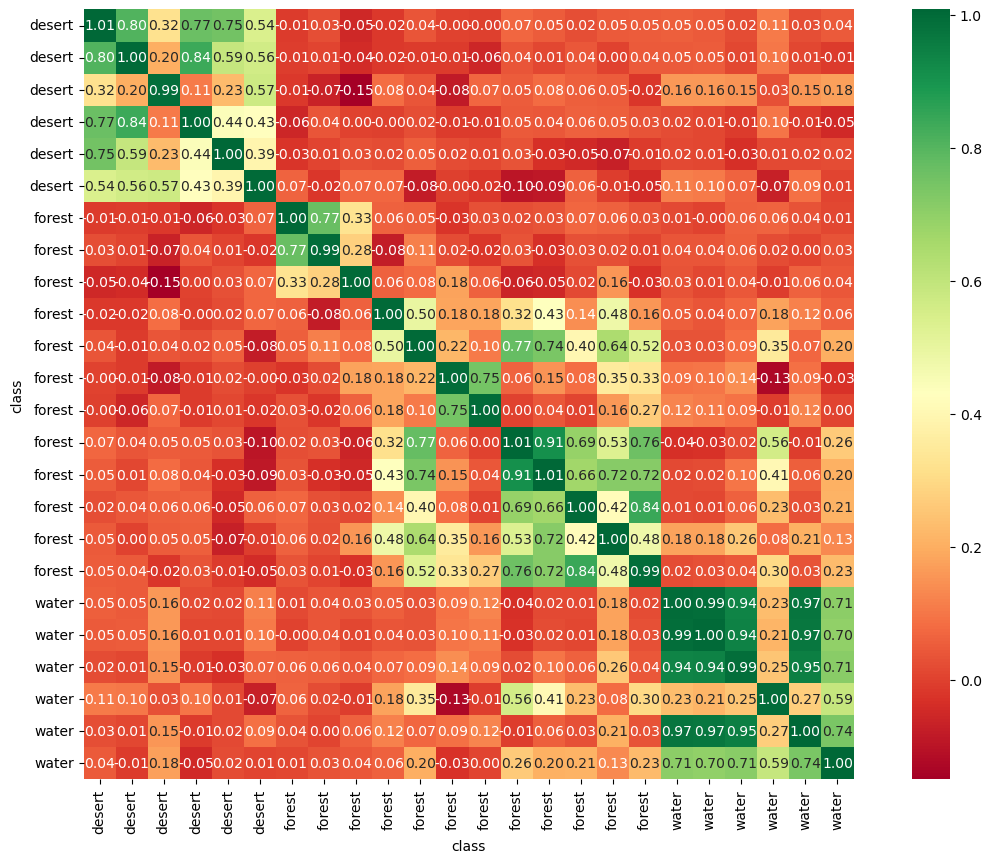

In [ ]:
# cosine distances between embeddings
def build_similarity_matrix(embs, labels):
    S = embs @ embs.T
    sim_df = pd.DataFrame(S, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(sim_df, annot=True, fmt=".2f", square=True, ax=ax,
                xticklabels=True, yticklabels=True, cmap="RdYlGn")

labels = df['class']
build_similarity_matrix(embs_np, labels)

In [22]:
reducer = umap.UMAP(n_components=3, n_neighbors=3, min_dist=0.0,
                    metric="cosine", random_state=42)
embs_3d = reducer.fit_transform(embs_np)

embs_3d

/opt/anaconda3/envs/cv_kau/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


array([[16.554468  ,  4.7189126 ,  3.147545  ],
       [16.42759   ,  4.941296  ,  3.0314758 ],
       [16.266777  ,  5.330159  ,  3.2725668 ],
       [16.451664  ,  4.616325  ,  3.2791667 ],
       [16.283428  ,  4.663098  ,  2.8741457 ],
       [16.36031   ,  5.240983  ,  3.2384558 ],
       [10.523707  , 13.551494  , -7.188084  ],
       [10.380811  , 13.694273  , -7.330927  ],
       [10.357487  , 13.717608  , -7.3542438 ],
       [ 6.4678483 , -0.6204378 , -2.2249851 ],
       [ 6.4129057 , -1.1983771 , -2.1879618 ],
       [ 6.0029225 ,  0.18046948, -2.0173597 ],
       [ 5.885179  ,  0.25274056, -1.8076677 ],
       [ 6.6344748 , -1.2137059 , -1.9248    ],
       [ 6.3300447 , -1.0070944 , -2.3894892 ],
       [ 6.468828  , -1.2860277 , -1.4549109 ],
       [ 6.190514  , -0.60241705, -2.5119781 ],
       [ 6.3351293 , -1.147266  , -1.3237679 ],
       [24.935684  , 13.882084  , 12.850154  ],
       [25.090137  , 13.742513  , 12.97844   ],
       [25.465067  , 13.577851  , 12.909

In [ ]:
# norm
embs_3d = embs_3d / np.linalg.norm(embs_3d, axis=1, keepdims=True)
embs_3d

array([[ 0.9460074 ,  0.26966292,  0.1798669 ],
       [ 0.9430062 ,  0.28364924,  0.17401826],
       [ 0.93338084,  0.30584228,  0.1877785 ],
       [ 0.94555944,  0.26532328,  0.18847011],
       [ 0.9478085 ,  0.27142465,  0.16729523],
       [ 0.93584526,  0.29979563,  0.1852467 ],
       [ 0.56570905,  0.7284697 , -0.38640034],
       [ 0.5556427 ,  0.73299897, -0.3923948 ],
       [ 0.5539989 ,  0.7337243 , -0.3933621 ],
       [ 0.94174534, -0.0903383 , -0.323967  ],
       [ 0.93196815, -0.17415652, -0.31796986],
       [ 0.94751954,  0.02848585, -0.3184262 ],
       [ 0.95511854,  0.04101782, -0.29337034],
       [ 0.94590956, -0.173044  , -0.27442816],
       [ 0.92536837, -0.1472238 , -0.34931153],
       [ 0.9577789 , -0.19041009, -0.21541505],
       [ 0.92287445, -0.08980761, -0.37448272],
       [ 0.96383196, -0.17454603, -0.20139918],
       [ 0.79669285,  0.4435313 ,  0.41056123],
       [ 0.7987041 ,  0.43747073,  0.41314772],
       [ 0.8054877 ,  0.4294822 ,  0.408

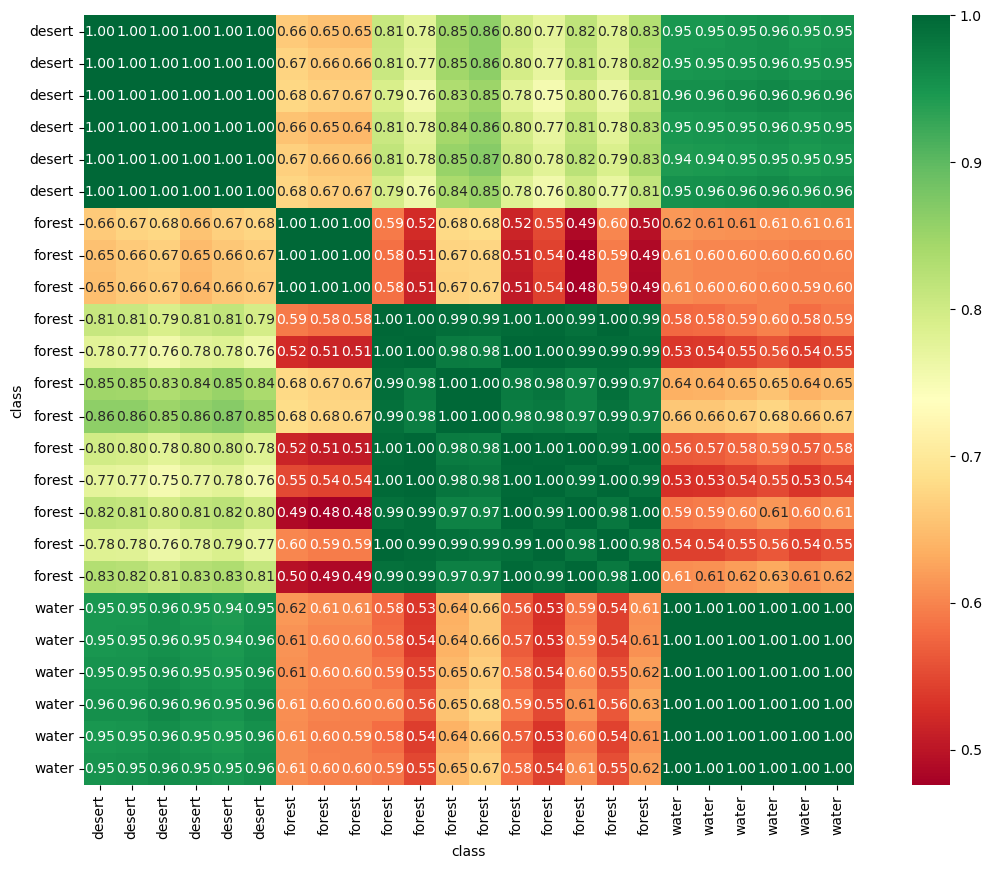

In [26]:
build_similarity_matrix(embs_3d, labels)

In [2]:
# df_visual = pd.DataFrame(embs_3d, columns=['x', 'y', 'z'])
# df_visual['class'] = labels
# df_visual.to_csv('out/test_embeddings_3d.csv')

df_visual = pd.read_csv('out/test_embeddings_3d.csv', index_col=0)
df_visual

,x,y,z,class
0,0.946007,0.269663,0.179867,desert
1,0.943006,0.283649,0.174018,desert
2,0.933381,0.305842,0.187778,desert
3,0.945559,0.265323,0.188470,desert
4,0.947809,0.271425,0.167295,desert
5,0.935845,0.299796,0.185247,desert
6,0.565709,0.728470,-0.386400,forest
7,0.555643,0.732999,-0.392395,forest
8,0.553999,0.733724,-0.393362,forest
9,0.941745,-0.090338,-0.323967,forest


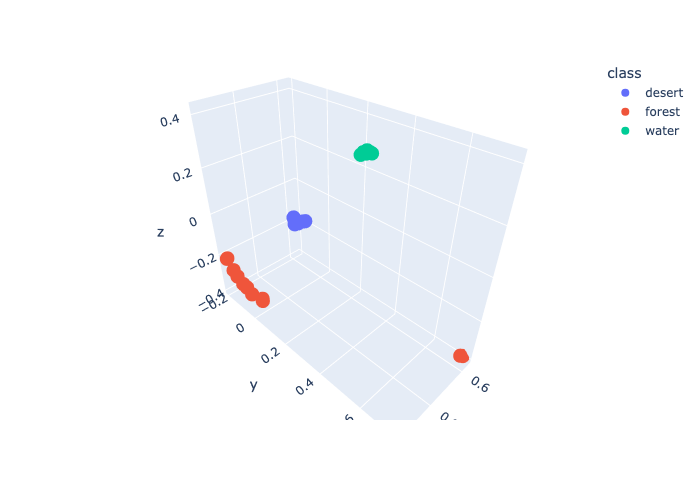

In [ ]:
fig = px.scatter_3d(
    df_visual, x="x", y="y", z="z",
    color="class",
    width=700, height=700
)

fig.show(renderer="png")
# renderer="vscode"